In [1]:
import sys
sys.path.append('..')
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import datetime
import theano_lstm
import numpy as np
import data_managers
import os

# Plotting
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline


Using gpu device 0: GeForce GTX TITAN X


In [2]:
data_butler = data_managers.character_data_manager('/home/arimorcos/Github/CS281-Final-Project/data manager/',
                                                   batch_size=128)

In [3]:
# Create network 
config.mode="FAST_RUN"
hidden_size = 128
network = theano_lstm.lstm_rnn(300,
                  [(hidden_size, hidden_size),
                   (hidden_size, hidden_size)],
                  150, dropout=0.2)
network.initialize_training_adadelta()

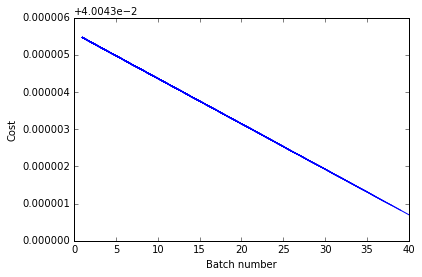

KeyboardInterrupt: 

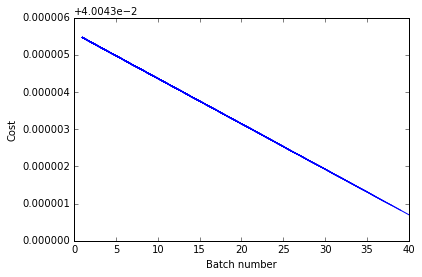

In [4]:
batch_size = 128
num_batches = 500
should_reinitialize = True

# Re-initialize network 
if should_reinitialize:
    network.initialize_network_weights()
    root_dir = '/media/1_TB_Internal/lstm_rnn_data'
    new_log_dir = os.path.join(root_dir, datetime.datetime.now().strftime('%y%m%d_%H%M%S'))
    network.set_log_dir(new_log_dir)

#Create plot 
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Batch number')
ax.set_ylabel('Cost')

# Initialize cost 
cost = []
    
# Get data
vectors, lengths, answer = data_butler.offer_data()

for batch in range(num_batches):

    # Step 
    temp_cost = network.adadelta_step(vectors, lengths, answer)
    cost.append(temp_cost.tolist())
    
    # Update plot 
    ax.plot(range(1, batch+2), cost, 'b')
    display.clear_output(wait=True)
    display.display(fig)

In [5]:
cost

[0.04004846513271332,
 0.04004834219813347,
 0.04004821926355362,
 0.04004809632897377,
 0.04004797711968422,
 0.04004785418510437,
 0.04004772752523422,
 0.04004761204123497,
 0.04004748538136482,
 0.04004736617207527,
 0.04004724323749542,
 0.04004712030291557,
 0.04004700109362602,
 0.040046874433755875,
 0.040046755224466324,
 0.040046632289886475,
 0.040046513080596924,
 0.040046386420726776,
 0.040046267211437225,
 0.040046144276857376,
 0.040046025067567825,
 0.040045902132987976,
 0.04004577919840813,
 0.04004565626382828,
 0.04004553332924843,
 0.04004540666937828,
 0.04004529118537903,
 0.04004516452550888,
 0.04004504531621933,
 0.04004492610692978,
 0.04004479944705963,
 0.04004468023777008,
 0.04004455730319023,
 0.04004443436861038,
 0.04004431515932083,
 0.040044188499450684,
 0.040044065564870834,
 0.040043946355581284,
 0.040043823421001434,
 0.040043700486421585]